In [5]:
!pip install --upgrade xgboost scikit-optimize
!pip install --upgrade xgboost
!pip install numpy==1.23.5
!pip install pipreqs


  Preparing metadata (setup.py) ... done
  Created wheel for some_package: filename=some_package-0.1-py3-none-any.whl size=1422 sha256=b21b865745872017aaeb10e2dd21668495a921ddd39332e78154e9dbe49b4a85
  Stored in directory: /root/.cache/pip/wheels/41/05/b7/d65681acb33c5f57ad3cc3fe2ac395a4c510666b0849d96a51
Successfully built some_package


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import pickle
import seaborn as sns
import skimage.metrics
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from sklearn.utils.extmath import safe_sparse_dot
from sklearn.metrics.pairwise import laplacian_kernel
from sklearn.utils import shuffle
import cupy as cp
from sklearn.model_selection import KFold, StratifiedKFold
from xgboost import DMatrix
from sklearn.metrics import make_scorer, mean_squared_error
from functools import partial
import warnings
warnings.simplefilter('ignore')

In [7]:
!pip freeze > requirements.txt

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CREASE-2D/Crease_2400_126/train_dataset_2400_126.csv')
df.head()

In [ ]:
df.shape

(11188800, 10)

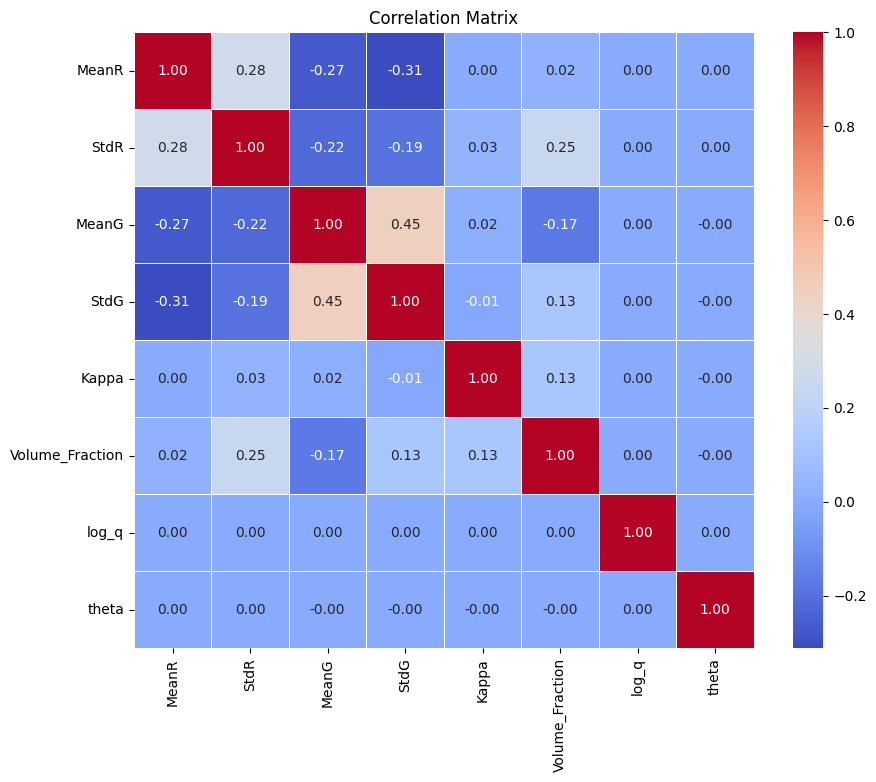

In [ ]:
excluded_columns = ['Sample ID', 'I_q']
df_filtered = df.drop(excluded_columns, axis=1)
correlation_matrix_filtered = df_filtered.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_filtered, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.savefig('correlation_matrix.svg', format='svg', bbox_inches='tight')
plt.show()

In [ ]:
# def normalize_target(y, min_val=None, max_val=None):
#     if min_val is None:
#         min_val = y.min()
#     if max_val is None:
#         max_val = y.max()
#     y_normalized = (y - min_val) / (max_val - min_val)
#     return y_normalized, min_val, max_val

# def denormalize_target(y_normalized, min_val, max_val):
#     y_denormalized = y_normalized * (max_val - min_val) + min_val
#     return y_denormalized

In [ ]:
df_shuffled = shuffle(df, random_state=189)
X = df_shuffled.drop(columns=['I_q', 'Sample ID'])
y = df_shuffled['I_q']
#y_norm, min_val, max_val = normalize_target(y)
X_gpu = cp.asarray(X)
y_gpu = cp.asarray(y)

In [ ]:
df_validate = pd.read_csv('/content/drive/MyDrive/CREASE-2D/Crease_2400_126/test_dataset_2400_126.csv')
df_validate.shape

(2797200, 10)

In [ ]:
df_validate['Sample ID'].unique()

array([   4,   11,   13,   29,   48,   51,   56,   64,   65,   72,   73,
         78,   92,   95,   98,   99,  101,  123,  127,  128,  141,  143,
        144,  145,  146,  155,  161,  165,  166,  172,  177,  180,  185,
        188,  189,  194,  206,  207,  209,  211,  215,  216,  224,  232,
        243,  246,  251,  253,  254,  256,  257,  258,  261,  262,  264,
        266,  273,  279,  283,  285,  289,  296,  297,  300,  304,  316,
        318,  319,  324,  325,  327,  335,  339,  342,  357,  366,  367,
        369,  370,  373,  379,  381,  386,  398,  400,  403,  404,  412,
        415,  419,  425,  432,  434,  442,  446,  458,  465,  472,  486,
        497,  507,  515,  519,  520,  521,  523,  524,  532,  536,  545,
        565,  569,  575,  576,  578,  579,  585,  600,  604,  609,  613,
        616,  620,  624,  635,  637,  645,  650,  652,  653,  658,  661,
        664,  669,  673,  676,  689,  701,  704,  705,  708,  722,  723,
        725,  728,  731,  733,  736,  741,  743,  7

In [ ]:
Validate_shuffled = shuffle(df_validate,random_state = 460)
X_test = Validate_shuffled.drop(columns=['I_q', 'Sample ID']).to_numpy()
y_test = Validate_shuffled['I_q']
#y_test_norm = normalize_target(y_test, min_val, max_val)
#X_test_gpu = cp.asarray(X_test)
#y_test_gpu = cp.asarray(y_test)

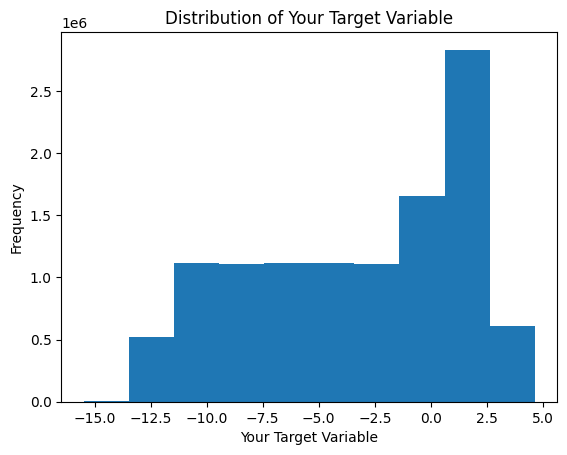

In [ ]:
plt.hist(y_gpu.get(), bins=10)
plt.xlabel('Your Target Variable')
plt.ylabel('Frequency')
plt.title('Distribution of Your Target Variable')
plt.show()

In [ ]:
param_space = {
    'n_estimators': np.arange(50, 1000, 50),
    'max_depth': np.arange(3, 15),
    'learning_rate': np.arange(0.001, 0.1, 0.001),
    'subsample': np.arange(0.5, 1.0, 0.1),
    'colsample_bytree': np.arange(0.5, 1.0, 0.1),
    'gamma': np.arange(0, 1, 0.1),
    'min_child_weight': np.arange(1, 10),
    'reg_lambda': np.arange(0.1, 1, 0.1),
    'reg_alpha': np.arange(0.1, 1, 0.1),
    'colsample_bylevel': np.arange(0.5, 1.0, 0.1)
}
xgb_reg = xgb.XGBRegressor(tree_method='hist', importance_type='cover',device='cuda', random_state=51)
opt = BayesSearchCV(
    xgb_reg,
    param_space,
    n_iter=50,
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=0,
    return_train_score=True,
    refit=False,
    optimizer_kwargs={'base_estimator': 'GP'}
)
opt.fit(X_gpu.get(), y_gpu.get())
best_params = opt.best_params_
best_score = opt.best_score_
print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: OrderedDict([('colsample_bylevel', 0.7999999999999999), ('colsample_bytree', 0.8999999999999999), ('gamma', 0.6000000000000001), ('learning_rate', 0.082), ('max_depth', 14), ('min_child_weight', 6), ('n_estimators', 200), ('reg_alpha', 0.7000000000000001), ('reg_lambda', 0.9), ('subsample', 0.7999999999999999)])
Best Score: 0.996111260922534


Best Parameters: OrderedDict([('colsample_bylevel', 0.7999999999999999), ('colsample_bytree', 0.8999999999999999), ('gamma', 0.6000000000000001), ('learning_rate', 0.082), ('max_depth', 14), ('min_child_weight', 6), ('n_estimators', 200), ('reg_alpha', 0.7000000000000001), ('reg_lambda', 0.9), ('subsample', 0.7999999999999999)])
Best Score: 0.996111260922534


In [ ]:
#Best Parameters: OrderedDict([('colsample_bylevel', 0.7), ('colsample_bytree', 0.7), ('gamma', 0.8), ('learning_rate', 0.046), ('max_depth', 14), ('min_child_weight', 3), ('n_estimators', 650), ('reg_alpha', 0.7000000000000001), ('reg_lambda', 0.30000000000000004), ('subsample', 0.7999999999999999)])
#Best Score: 0.9960200500669313
best_params = {'colsample_bylevel':0.7999999999999999,'colsample_bytree':0.8999999999999999,'gamma':0.6000000000000001,'learning_rate':0.082,'max_depth':14,
                   'min_child_weight':6,'n_estimators':200,'reg_lambda':0.9,'reg_alpha':0.7000000000000001,'subsample':0.7999999999999999}
final_xgb = xgb.XGBRegressor(**best_params,device='cuda', tree_method='hist', importance_type='cover', random_state=51)
final_xgb.fit(X,y)
cover_importance = final_xgb.feature_importances_


In [ ]:
X.columns

Index(['MeanR', 'StdR', 'MeanG', 'StdG', 'Kappa', 'Volume_Fraction', 'log_q',
       'theta'],
      dtype='object')

In [ ]:
cover_importance = [0.14052474, 0.10679282, 0.07481752, 0.05320102, 0.06685552,
       0.07902309, 0.4176966 , 0.06108872]
features = ['MeanR', 'StdR', 'MeanG', 'StdG', 'Kappa', 'Volume_Fraction', 'log_q',
       'theta']

array([0.14052474, 0.10679282, 0.07481752, 0.05320102, 0.06685552,
       0.07902309, 0.4176966 , 0.06108872], dtype=float32)

array([0.14052474, 0.10679282, 0.07481752, 0.05320102, 0.06685552,
       0.07902309, 0.4176966 , 0.06108872], dtype=float32)

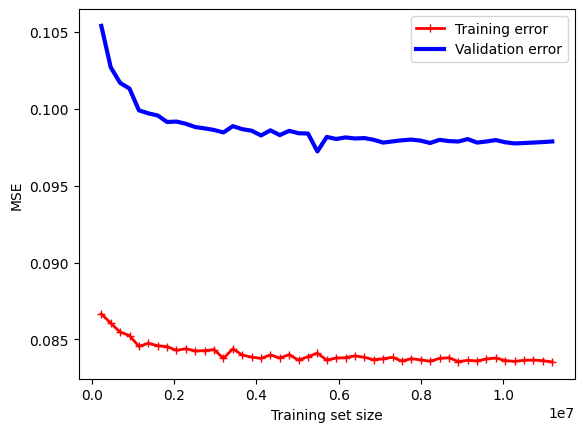

In [ ]:
train_sizes = np.linspace(50, len(X), 50, dtype=int)
train_mse_errors, val_mse_errors = [], []
train_r2_errors, val_r2_errors = [], []
for m in train_sizes:
    final_xgb.fit(X[:m], y[:m])
    y_train_predict = final_xgb.predict(X[:m])
    y_val_predict = final_xgb.predict(X_test)
    #y_denorm = denormalize_target(y_train_predict, min_val, max_val)
    #y_test_denorm = denormalize_target(y_val_predict, min_val, max_val)
    train_mse_errors.append(mean_squared_error(y[:m], y_train_predict))
    val_mse_errors.append(mean_squared_error(y_test, y_val_predict))
    train_r2_errors.append(r2_score(y[:m], y_train_predict))
    val_r2_errors.append(r2_score(y_test, y_val_predict))
fig, ax = plt.subplots()
plt.plot(train_sizes[1:], train_mse_errors[1:], 'r-+', linewidth=2, label='Training error')
plt.plot(train_sizes[1:], val_mse_errors[1:], 'b-', linewidth=3, label='Validation error')
plt.xlabel('Training set size')
plt.ylabel('MSE')
#plt.ylim((0.98, 1))
#plt.yscale("log")
plt.legend()
image_name = 'Learning_Curve'
image_format = 'svg'
#plt.savefig(f'{image_name}.{image_format}', format=image_format)
plt.show()

In [ ]:
learning_curve_data = pd.DataFrame({
    'Training Size': train_sizes,
    'Training MSE Error': train_mse_errors,
    'Validation MSE Error': val_mse_errors,
    'Training R2 Error': train_r2_errors,
    'validating R2 Error': val_r2_errors

})
print(learning_curve_data)
learning_curve_data.to_csv('/content/drive/MyDrive/CREASE-2D/Crease_2400_126/learning_curve_data_2400_126_.csv', index=False)

    Training Size  Training MSE Error  Validation MSE Error  \
0              50            0.174650              1.155245   
1          228391            0.086664              0.105391   
2          456733            0.086061              0.102701   
3          685075            0.085478              0.101687   
4          913417            0.085251              0.101317   
5         1141759            0.084550              0.099904   
6         1370101            0.084750              0.099706   
7         1598442            0.084593              0.099565   
8         1826784            0.084535              0.099143   
9         2055126            0.084292              0.099170   
10        2283468            0.084398              0.099026   
11        2511810            0.084253              0.098813   
12        2740152            0.084272              0.098728   
13        2968493            0.084342              0.098623   
14        3196835            0.083770              0.09

In [ ]:
best_params = {'colsample_bylevel':0.7999999999999999,'colsample_bytree':0.8999999999999999,'gamma':0.6000000000000001,'learning_rate':0.082,'max_depth':14,
                   'min_child_weight':6,'n_estimators':200,'reg_lambda':0.9,'reg_alpha':0.7000000000000001,'subsample':0.7999999999999999}
final_xgb = xgb.XGBRegressor(**best_params, tree_method='hist', importance_type='gain', random_state=51)
final_xgb.fit(X, y)
y_pred = final_xgb.predict(X_test)
y_train_predict = final_xgb.predict(X)
train_mse = mean_squared_error(y, y_train_predict)
train_r2 = r2_score(y,y_train_predict)
test_mse = mean_squared_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

In [ ]:
print('Training Mean squared error:', train_mse )
print('Training r2 error:', train_r2 )
print('Test Mean squared error:', test_mse )
print('Test r2 score error:', train_r2 )

Training Mean squared error: 0.08374768762735213
Training r2 error: 0.9962436696851945
Test Mean squared error: 0.09976331778334184
Test r2 score error: 0.9962436696851945


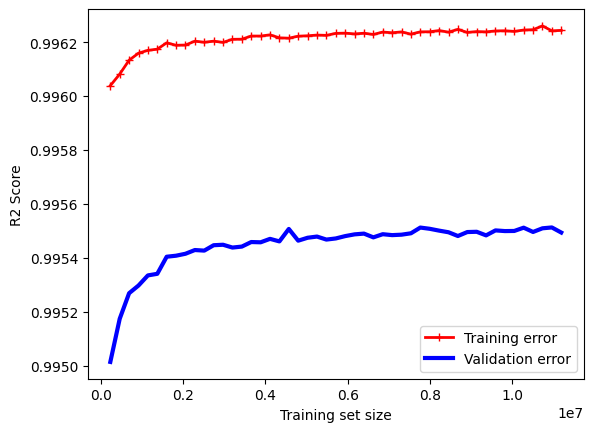

In [ ]:
fig, ax = plt.subplots()
plt.plot(train_sizes[1:], train_errors[1:], 'r-+', linewidth=2, label='Training error')
plt.plot(train_sizes[1:], val_errors[1:], 'b-', linewidth=3, label='Validation error')
plt.xlabel('Training set size')
plt.ylabel('R2 Score')
#plt.ylim((0.9, 1))
#plt.yscale("log")
plt.legend()
image_name = 'Learning_Curve'
image_format = 'svg'
plt.savefig(f'{image_name}.{image_format}', format=image_format)
plt.show()

In [ ]:
final_xgb.save_model('/content/drive/MyDrive/CREASE-2D/Crease_2400_126/xgbmodel_2400_126.json')

In [ ]:
loaded_model = xgb.Booster(model_file='/content/drive/MyDrive/CREASE-2D/Crease_2400_126/xgbmodel_2400_126.json')

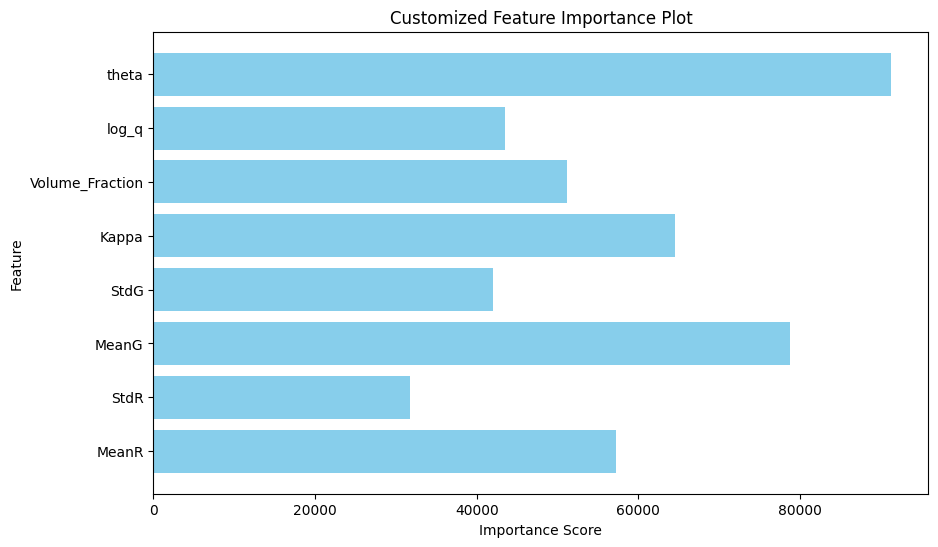

In [ ]:
feature_importance = loaded_model.get_fscore()
feature_names = list(feature_importance.keys())
importance_scores = list(feature_importance.values())
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importance_scores, color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Customized Feature Importance Plot')
plt.show()

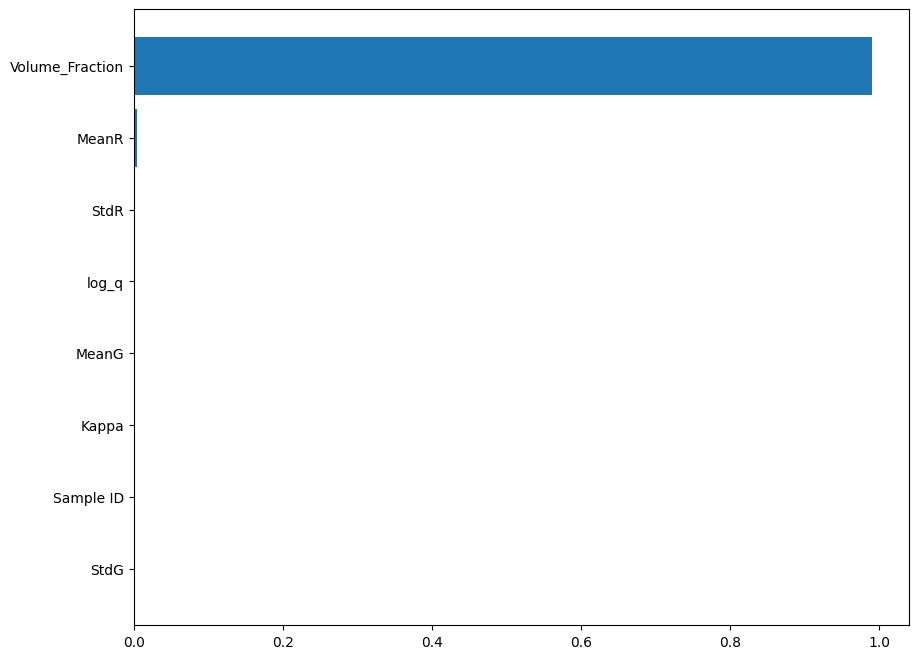

In [ ]:
feature_importance = final_xgb.feature_importances_
sorted_indices = np.argsort(feature_importance)
sorted_feature_importance = [feature_importance[i] for i in sorted_indices]
#sorted_feature_names = [feature_names[i] for i in sorted_indices]
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_feature_importance)), sorted_feature_importance, tick_label=sorted_feature_names)
plt.show()

In [ ]:
feature_importance = final_xgb.feature_importances_
feature_names = df.columns[:-1]

# Create a list of tuples containing feature names and their importance scores
feature_importance_tuples = list(zip(feature_names, feature_importance))

# Sort the list of tuples based on importance scores
sorted_feature_importance_tuples = sorted(feature_importance_tuples, key=lambda x: x[1], reverse=True)

# Print or store the sorted feature importance scores and names
for feature_name, importance_score in sorted_feature_importance_tuples:
    print(f"{feature_name}: {importance_score}")

# If you want to save the scores to a file, you can use the following:
# with open('feature_importance_scores.txt', 'w') as file:
#     for feature_name, importance_score in sorted_feature_importance_tuples:
#         file.write(f"{feature_name}: {importance_score}\n")


Volume_Fraction: 0.3869056701660156
MeanR: 0.16586296260356903
StdR: 0.11458925157785416
Sample ID: 0.10039961338043213
MeanG: 0.06624092906713486
Kappa: 0.05757829174399376
StdG: 0.054674796760082245
log_q: 0.0537484809756279


In [ ]:
df.columns[:-1]

Index(['MeanR', 'StdR', 'MeanG', 'StdG', 'Kappa', 'Sample ID',
       'Volume_Fraction', 'log_q', 'theta'],
      dtype='object')

In [ ]:
df_validate['Sample ID'].unique()

array([   4,    6,    8,    9,   11,   13,   24,   25,   27,   29,   33,
         37,   41,   44,   47,   48,   51,   54,   55,   56,   64,   65,
         67,   72,   73,   78,   86,   91,   92,   95,   96,   98,   99,
        100,  101,  116,  123,  127,  128,  141,  143,  144,  145,  146,
        155,  158,  159,  160,  161,  165,  166,  167,  172,  177,  178,
        179,  180,  181,  185,  188,  189,  190,  191,  194,  205,  206,
        207,  209,  211,  214,  215,  216,  219,  224,  225,  226,  232,
        236,  237,  238,  243,  246,  247,  251,  253,  254,  255,  256,
        257,  258,  261,  262,  264,  266,  273,  274,  279,  283,  285,
        287,  289,  290,  296,  297,  300,  301,  304,  306,  315,  316,
        317,  318,  319,  322,  324,  325,  327,  329,  335,  336,  338,
        339,  342,  357,  359,  364,  366,  367,  369,  370,  371,  373,
        379,  381,  386,  391,  398,  400,  403,  404,  407,  411,  412,
        413,  415,  419,  425,  426,  430,  432,  4

In [ ]:
unique_sample_ids = df['Sample ID'].unique()
mse_list, r2_list, psnr_list, ssim_list = [], [], [], []

for sample_id in unique_sample_ids:
    filtered = df[df['Sample ID'] == sample_id]
    X_sample_test = filtered.drop(columns=['I_q', 'Sample ID'])
    y_sample_test = filtered['I_q']

    dmatrix_test = xgb.DMatrix(X_sample_test)
    predicted = loaded_model.predict(dmatrix_test)

    # Calculate metrics
    r2_score_ = r2_score(y_sample_test, predicted)
    mse = mean_squared_error(y_sample_test, predicted)

    # Reshape matrices
    predicted_matrix = np.reshape(predicted, (126, 37))
    original_matrix = np.reshape(y_sample_test.to_numpy(), (126, 37))

    range_3_1 = np.max(y_sample_test) - np.min(predicted)
    psnr_3_1 = skimage.metrics.peak_signal_noise_ratio(original_matrix, predicted_matrix, data_range=range_3_1)
    ssim_3_1 = skimage.metrics.structural_similarity(original_matrix, predicted_matrix, data_range=range_3_1)

    # Append scores to lists
    mse_list.append(mse)
    r2_list.append(r2_score_)
    psnr_list.append(psnr_3_1)
    ssim_list.append(ssim_3_1)

# Create a DataFrame
results_df = pd.DataFrame({
    'Sample ID': unique_sample_ids,
    'MSE': mse_list,
    'R2 Score': r2_list,
    'PSNR': psnr_list,
    'SSIM': ssim_list
})
results_df.to_csv('training_results.csv', index=False)


In [ ]:
unique_sample_ids = df_validate['Sample ID'].unique()
mse_list, r2_list, psnr_list, ssim_list = [], [], [], []

for sample_id in unique_sample_ids:
    filtered = df_validate[df_validate['Sample ID'] == sample_id]
    X_sample_test = filtered.drop(columns=['I_q', 'Sample ID'])
    y_sample_test = filtered['I_q']

    dmatrix_test = xgb.DMatrix(X_sample_test)
    predicted = loaded_model.predict(dmatrix_test)

    # Calculate metrics
    r2_score_ = r2_score(y_sample_test, predicted)
    mse = mean_squared_error(y_sample_test, predicted)

    # Reshape matrices
    predicted_matrix = np.reshape(predicted, (126, 37))
    original_matrix = np.reshape(y_sample_test.to_numpy(), (126, 37))

    range_3_1 = np.max(y_sample_test) - np.min(predicted)
    psnr_3_1 = skimage.metrics.peak_signal_noise_ratio(original_matrix, predicted_matrix, data_range=range_3_1)
    ssim_3_1 = skimage.metrics.structural_similarity(original_matrix, predicted_matrix, data_range=range_3_1)

    # Append scores to lists
    mse_list.append(mse)
    r2_list.append(r2_score_)
    psnr_list.append(psnr_3_1)
    ssim_list.append(ssim_3_1)

# Create a DataFrame
results_df = pd.DataFrame({
    'Sample ID': unique_sample_ids,
    'MSE': mse_list,
    'R2 Score': r2_list,
    'PSNR': psnr_list,
    'SSIM': ssim_list
})
results_df.to_csv('validation_results.csv', index=False)


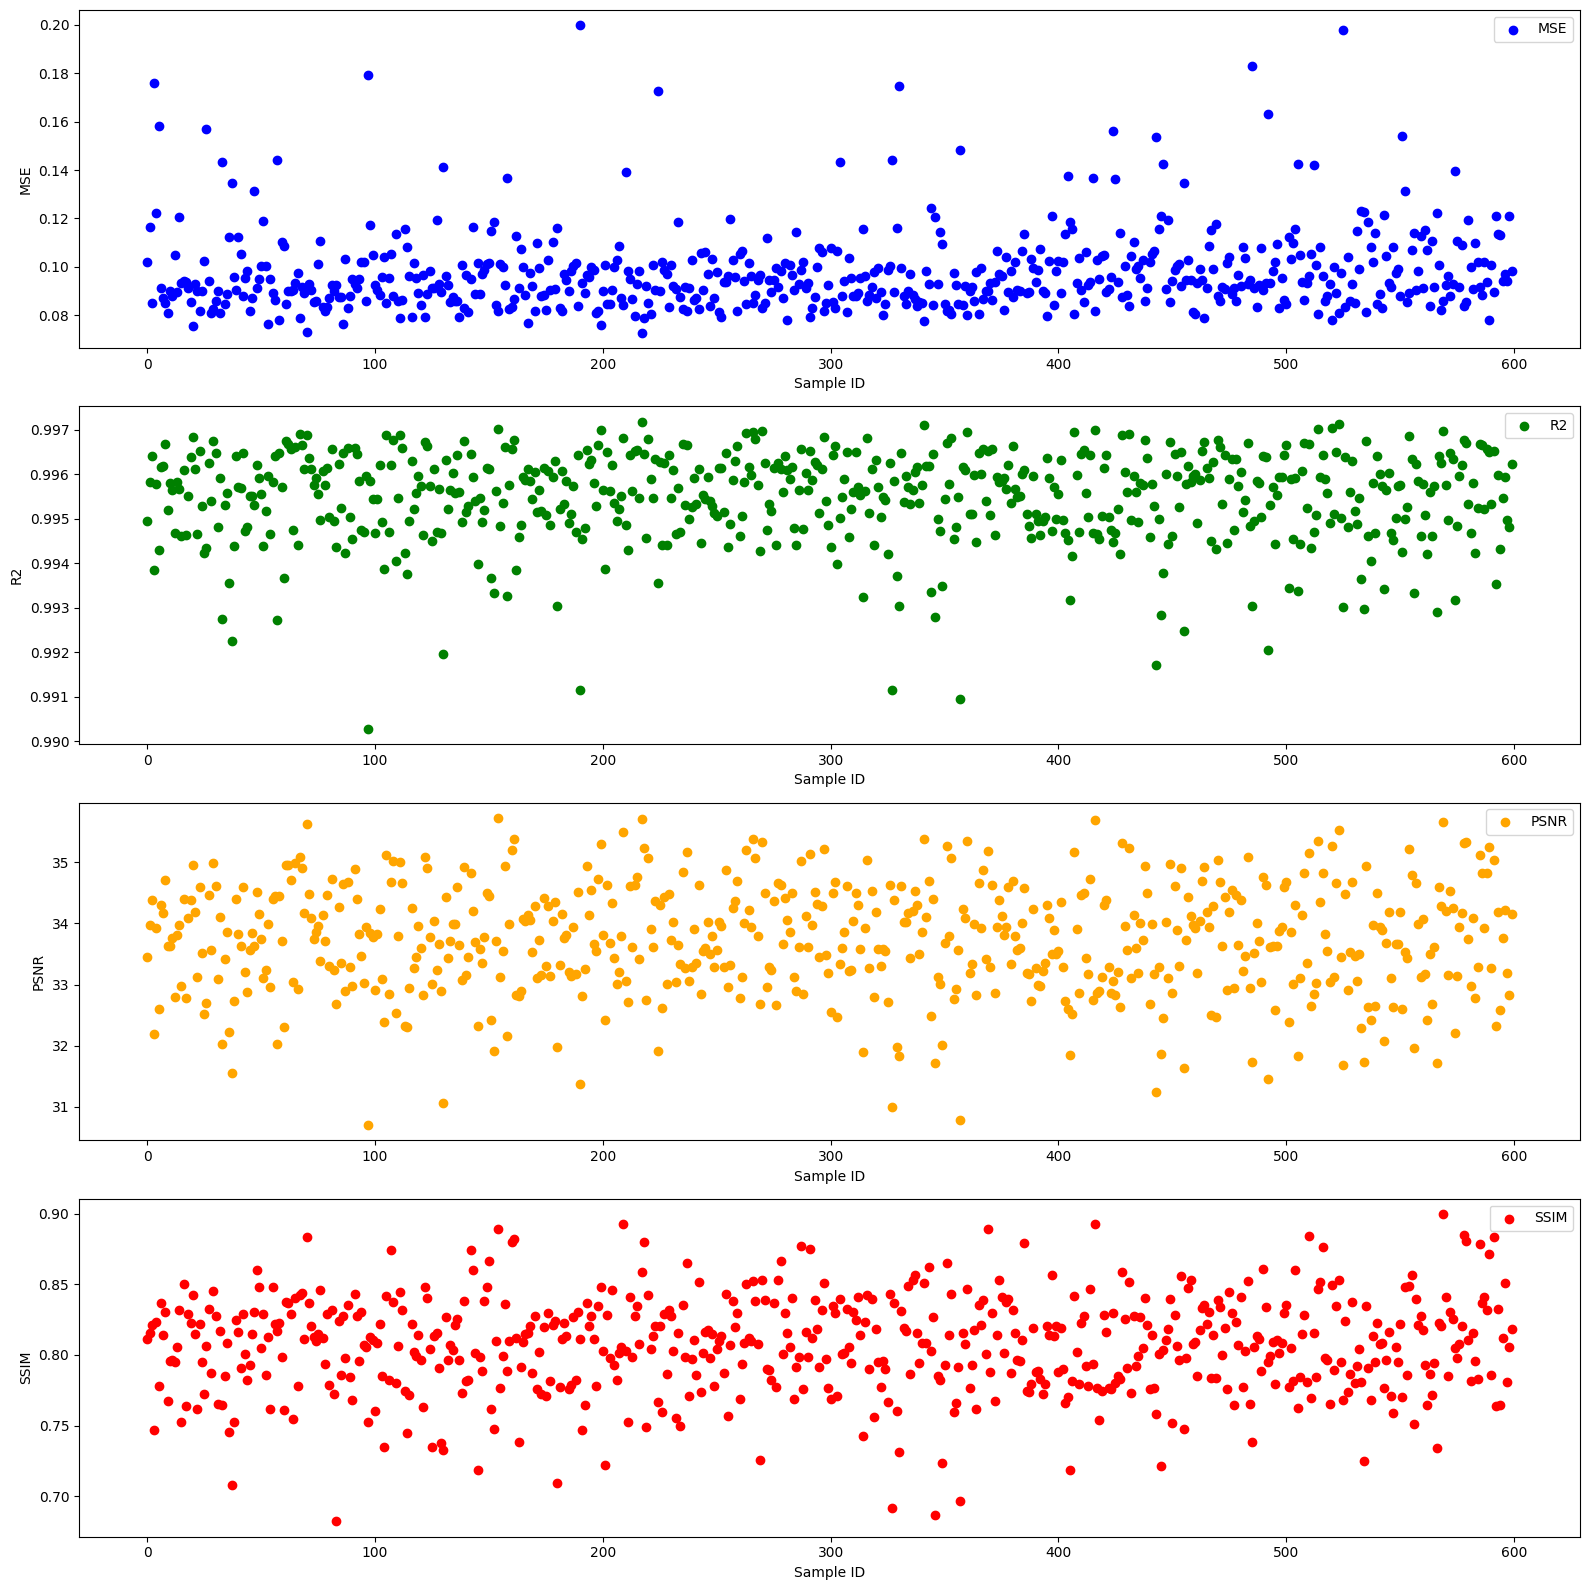

In [ ]:
unique_sample_ids = df_validate['Sample ID'].unique()
fig, axs = plt.subplots(4, 1, figsize=(16, 16))
colors = ['blue', 'green', 'orange', 'red']
mse_list = []
r2_list = []
psnr_list = []
ssim_list = []

for i, sample_id in enumerate(unique_sample_ids):
    filtered = df_validate[df_validate['Sample ID'] == sample_id]
    X_sample_test = filtered.drop(columns=['I_q', 'Sample ID'])
    y_sample_test = filtered['I_q']
    dmatrix_test = xgb.DMatrix(X_sample_test)
    predicted = loaded_model.predict(dmatrix_test)
    r2_score_ = r2_score(y_sample_test, predicted)
    mse = mean_squared_error(y_sample_test, predicted)
    predicted_matrix = np.reshape(predicted, (126, 37))
    original_matrix = np.reshape(y_sample_test.to_numpy(), (126, 37))
    range_3_1 = np.max(y_sample_test) - np.min(predicted)
    psnr_3_1 = skimage.metrics.peak_signal_noise_ratio(original_matrix, predicted_matrix, data_range=range_3_1)
    ssim_3_1 = skimage.metrics.structural_similarity(original_matrix, predicted_matrix, data_range=range_3_1)

    # Append scores to lists
    mse_list.append(mse)
    r2_list.append(r2_score_)
    psnr_list.append(psnr_3_1)
    ssim_list.append(ssim_3_1)

# Scatter plots for each score
axs[0].scatter(range(len(unique_sample_ids)), mse_list, color=colors[0])
axs[1].scatter(range(len(unique_sample_ids)), r2_list, color=colors[1])
axs[2].scatter(range(len(unique_sample_ids)), psnr_list, color=colors[2])
axs[3].scatter(range(len(unique_sample_ids)), ssim_list, color=colors[3])

# Set labels
for ax in axs:
    ax.set_xlabel('Sample ID')

axs[0].set_ylabel('MSE')
axs[1].set_ylabel('R2')
axs[2].set_ylabel('PSNR')
axs[3].set_ylabel('SSIM')

# Add legend outside the loop
axs[0].legend(['MSE'], loc='upper right')
axs[1].legend(['R2'], loc='upper right')
axs[2].legend(['PSNR'], loc='upper right')
axs[3].legend(['SSIM'], loc='upper right')

# Adjust layout
plt.tight_layout()
plt.show()


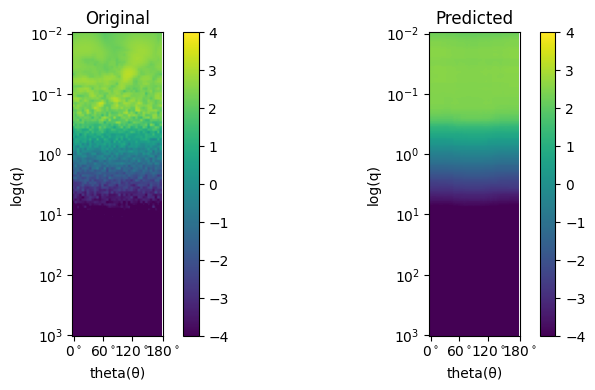

In [ ]:
filtered = df_validate[df_validate['Sample ID'] == 224]
X_sample_test = filtered.drop(columns=['I_q', 'Sample ID']).to_numpy()
y_sample_test = filtered['I_q']
predicted = final_xgb.predict(X_sample_test)
r2_score_= r2_score(y_sample_test,predicted)
predicted_matrix = np.reshape(predicted, (126,37))
original_matrix = np.reshape(y_sample_test.to_numpy(), (126,37))
mse = mean_squared_error(y_sample_test, predicted)
range_3_1 = np.max(y_sample_test) - np.min(predicted)
psnr_3_1 = skimage.metrics.peak_signal_noise_ratio(original_matrix, predicted_matrix,data_range=range_3_1)
ssim_3_1 = skimage.metrics.structural_similarity(original_matrix, predicted_matrix,data_range=range_3_1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
# Plotting the first image
im1 = ax1.imshow(original_matrix, cmap='viridis', vmin=-4, vmax=4)
x_positions = [0,12,24,37]
x_ticks = ["0$^\circ$", "60$^\circ$", "120$^\circ$", "180$^\circ$"]
y_positions = [0,25,50,75,100,125]
y_ticks = ["$10^{-2}$", "$10^{-1}$", "$10^0$", "$10^1$", "$10^2$", "$10^3$"]
ax1.set_xticks(x_positions,x_ticks)
ax1.set_yticks(y_positions,y_ticks)
ax1.set_title('Original')
ax1.set_xlabel("theta(θ)")
ax1.set_ylabel("log(q)")
cbar1 = fig.colorbar(im1, ax=ax1)
# Plotting the second image
im2 = ax2.imshow(predicted_matrix, cmap='viridis', vmin=-4, vmax=4)
ax2.set_xticks(x_positions,x_ticks)
ax2.set_yticks(y_positions,y_ticks)
ax2.set_title('Predicted')
ax2.set_xlabel("theta(θ)")
ax2.set_ylabel("log(q)")
cbar2 = fig.colorbar(im2, ax=ax2)
plt.tight_layout()
#fig.savefig('least_test_sample_1609_2D.svg', format='svg')


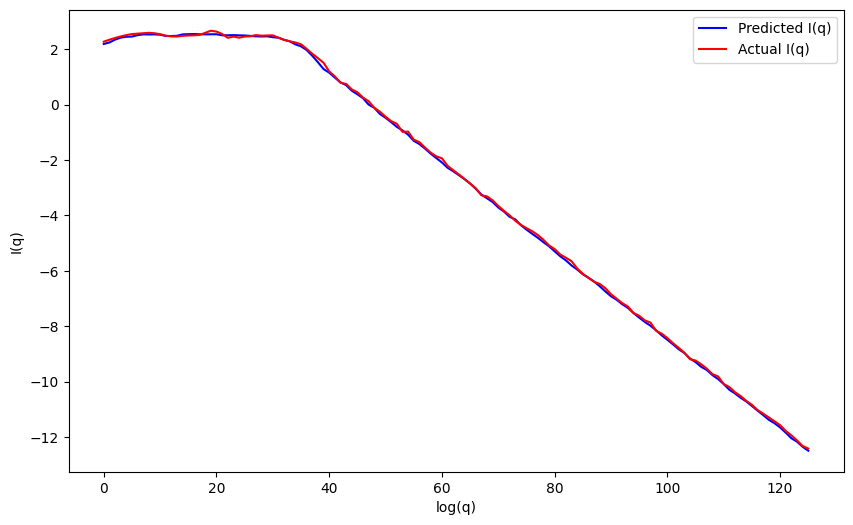

Mean Squared Error image: 0.0877908016976975
R-squared image: 0.996474728470015
PSNR: 34.59909313915547
SSIM: 0.8287759994403567


In [ ]:
f_array_pred = np.reshape(predicted, (126, 37))
f_array_actual = np.reshape(np.array(y_sample_test), (126, 37))

average_pred = np.mean(f_array_pred, axis=1)
average_actual = np.mean(f_array_actual, axis=1)
plt.figure(figsize=(10, 6))
plt.xlabel("log(q)")
plt.ylabel("I(q)")
#plt.title("Average Predictions vs. Average Actual")

plt.plot(average_pred, label="Predicted I(q)", color="blue", linestyle="-")
plt.plot(average_actual, label="Actual I(q)", color="red", linestyle="-")
plt.legend()
fig = plt.gcf()
fig.savefig('least_test_sample_1609_1D.svg', format='svg')
plt.show()
print("Mean Squared Error image:", mse)
print("R-squared image:", r2_score_)
print('PSNR:',psnr_3_1)
print('SSIM:', ssim_3_1)

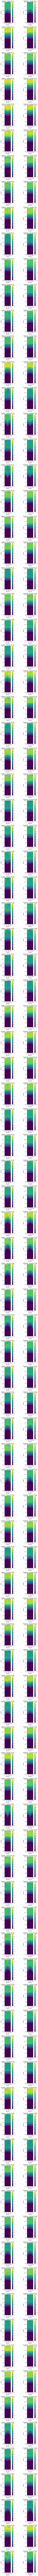

In [ ]:
unique_sample_ids = df_validate['Sample ID'].unique()[:100]
fig, axs = plt.subplots(len(unique_sample_ids), 2, figsize=(8, 4 * len(unique_sample_ids)))
for i, sample_id in enumerate(unique_sample_ids):
    filtered = df_validate[df_validate['Sample ID'] == sample_id]
    X_sample_test = filtered.drop(columns=['I_q', 'Sample ID']).to_numpy()
    y_sample_test = filtered['I_q']
    predicted = final_xgb.predict(X_sample_test)
    r2_score_ = r2_score(y_sample_test, predicted)
    predicted_matrix = np.reshape(predicted, (126, 37))
    original_matrix = np.reshape(y_sample_test.to_numpy(), (126, 37))
    mse = mean_squared_error(y_sample_test, predicted)
    range_3_1 = np.max(y_sample_test) - np.min(predicted)
    psnr_3_1 = skimage.metrics.peak_signal_noise_ratio(original_matrix, predicted_matrix, data_range=range_3_1)
    ssim_3_1 = skimage.metrics.structural_similarity(original_matrix, predicted_matrix, data_range=range_3_1)
    # Plotting the first image
    im1 = axs[i, 0].imshow(original_matrix, cmap='viridis', vmin=-4, vmax=4)
    x_positions = [0, 12, 24, 37]
    x_ticks = ["0$^\circ$", "60$^\circ$", "120$^\circ$", "180$^\circ$"]
    y_positions = [0, 25, 50, 75, 100, 125]
    y_ticks = ["$10^{-2}$", "$10^{-1}$", "$10^0$", "$10^1$", "$10^2$", "$10^3$"]
    axs[i, 0].set_xticks(x_positions, x_ticks)
    axs[i, 0].set_yticks(y_positions, y_ticks)
    axs[i, 0].set_title(f'Original - Sample ID {sample_id}')
    axs[i, 0].set_xlabel("theta(θ)")
    axs[i, 0].set_ylabel("log(q)")
    cbar1 = fig.colorbar(im1, ax=axs[i, 0])
    # Plotting the second image
    im2 = axs[i, 1].imshow(predicted_matrix, cmap='viridis', vmin=-4, vmax=4)
    axs[i, 1].set_xticks(x_positions, x_ticks)
    axs[i, 1].set_yticks(y_positions, y_ticks)
    axs[i, 1].set_title(f'Predicted - Sample ID {sample_id}')
    axs[i, 1].set_xlabel("theta(θ)")
    axs[i, 1].set_ylabel("log(q)")
    cbar2 = fig.colorbar(im2, ax=axs[i, 1])
# Adjust layout
plt.tight_layout()
fig.savefig('test_samples_200_300.svg', format='svg')
plt.show()

In [ ]:
max_mse_index = mse_list.index(max(mse_list))
df_validate['Sample ID'].unique()[max_mse_index]

978

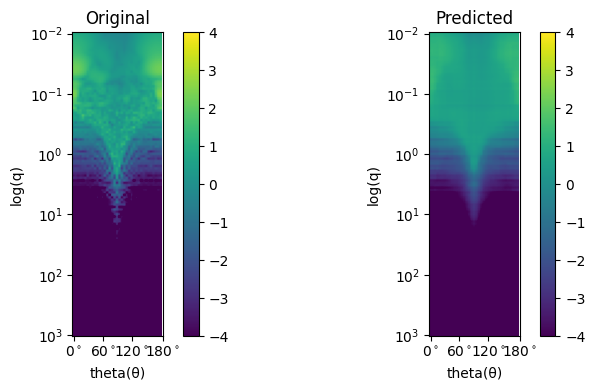

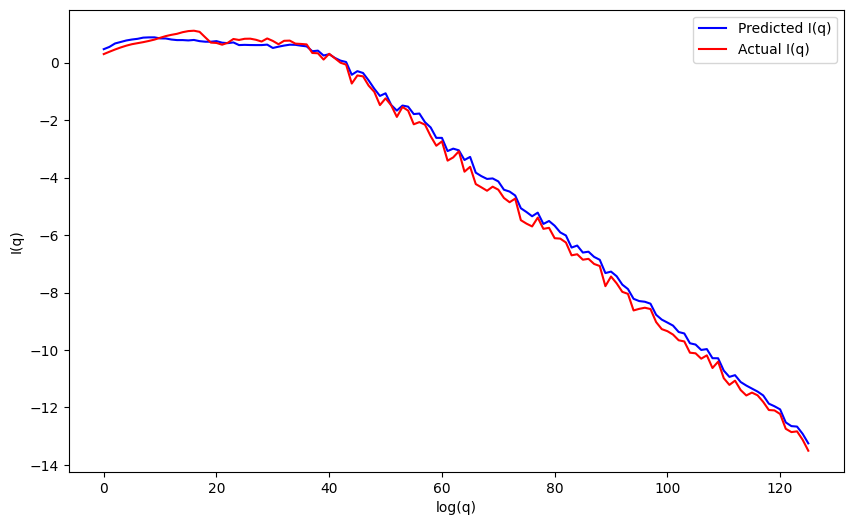

Mean Squared Error image: 0.19977128631632873
R-squared image: 0.9911481838728253
PSNR: 31.381626712742438
SSIM: 0.8115520306870495


In [ ]:
filtered = df_validate[df_validate['Sample ID'] == 978]
X_sample_test = filtered.drop(columns=['I_q', 'Sample ID']).to_numpy()
y_sample_test = filtered['I_q']
predicted = final_xgb.predict(X_sample_test)
r2_score_= r2_score(y_sample_test,predicted)
predicted_matrix = np.reshape(predicted, (126,37))
original_matrix = np.reshape(y_sample_test.to_numpy(), (126,37))
mse = mean_squared_error(y_sample_test, predicted)
range_3_1 = np.max(y_sample_test) - np.min(predicted)
psnr_3_1 = skimage.metrics.peak_signal_noise_ratio(original_matrix, predicted_matrix,data_range=range_3_1)
ssim_3_1 = skimage.metrics.structural_similarity(original_matrix, predicted_matrix,data_range=range_3_1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
# Plotting the first image
im1 = ax1.imshow(original_matrix, cmap='viridis', vmin=-4, vmax=4)
x_positions = [0,12,24,37]
x_ticks = ["0$^\circ$", "60$^\circ$", "120$^\circ$", "180$^\circ$"]
y_positions = [0,25,50,75,100,125]
y_ticks = ["$10^{-2}$", "$10^{-1}$", "$10^0$", "$10^1$", "$10^2$", "$10^3$"]
ax1.set_xticks(x_positions,x_ticks)
ax1.set_yticks(y_positions,y_ticks)
ax1.set_title('Original')
ax1.set_xlabel("theta(θ)")
ax1.set_ylabel("log(q)")
cbar1 = fig.colorbar(im1, ax=ax1)
# Plotting the second image
im2 = ax2.imshow(predicted_matrix, cmap='viridis', vmin=-4, vmax=4)
ax2.set_xticks(x_positions,x_ticks)
ax2.set_yticks(y_positions,y_ticks)
ax2.set_title('Predicted')
ax2.set_xlabel("theta(θ)")
ax2.set_ylabel("log(q)")
cbar2 = fig.colorbar(im2, ax=ax2)
plt.tight_layout()
#fig.savefig('least_test_sample_1609_2D.svg', format='svg')
f_array_pred = np.reshape(predicted, (126, 37))
f_array_actual = np.reshape(np.array(y_sample_test), (126, 37))

average_pred = np.mean(f_array_pred, axis=1)
average_actual = np.mean(f_array_actual, axis=1)
plt.figure(figsize=(10, 6))
plt.xlabel("log(q)")
plt.ylabel("I(q)")
#plt.title("Average Predictions vs. Average Actual")

plt.plot(average_pred, label="Predicted I(q)", color="blue", linestyle="-")
plt.plot(average_actual, label="Actual I(q)", color="red", linestyle="-")
plt.legend()
fig = plt.gcf()
fig.savefig('least_test_sample_1609_1D.svg', format='svg')
plt.show()
print("Mean Squared Error image:", mse)
print("R-squared image:", r2_score_)
print('PSNR:',psnr_3_1)
print('SSIM:', ssim_3_1)

In [ ]:
min_ssim_index = ssim_list.index(min(ssim_list))
df_validate['Sample ID'].unique()[min_ssim_index]

1853

In [ ]:
max_ssim_index = ssim_list.index(max(ssim_list))
df_validate['Sample ID'].unique()[max_ssim_index]

459

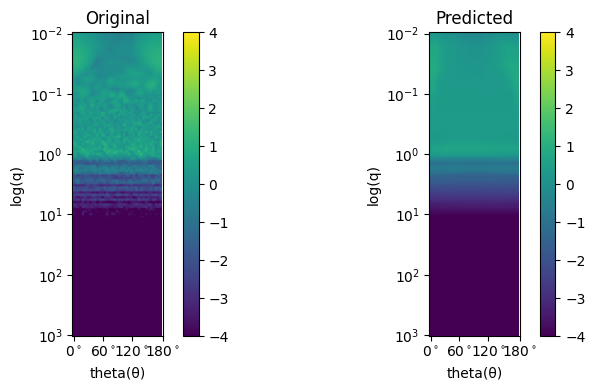

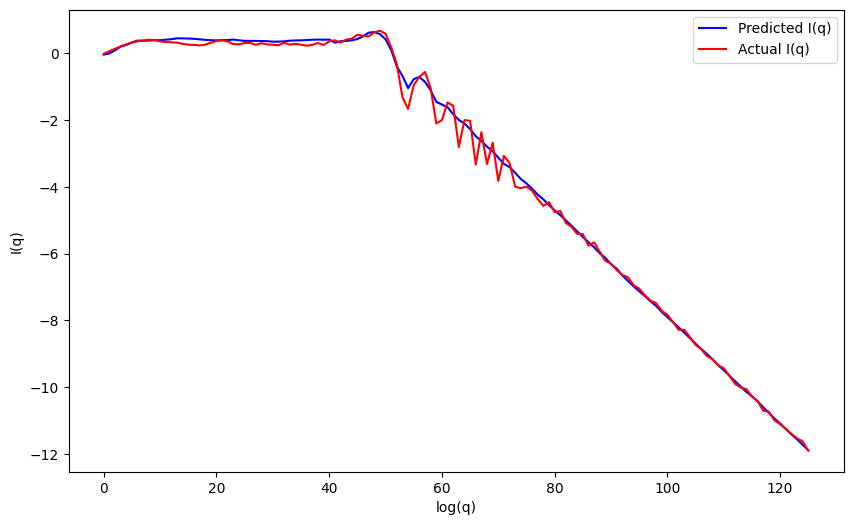

Mean Squared Error image: 0.1204842473845067
R-squared image: 0.9927995234500872
PSNR: 31.723781317798903
SSIM: 0.6867638596946976


In [ ]:
filtered = df_validate[df_validate['Sample ID'] == 1853]
X_sample_test = filtered.drop(columns=['I_q', 'Sample ID']).to_numpy()
y_sample_test = filtered['I_q']
predicted = final_xgb.predict(X_sample_test)
r2_score_= r2_score(y_sample_test,predicted)
predicted_matrix = np.reshape(predicted, (126,37))
original_matrix = np.reshape(y_sample_test.to_numpy(), (126,37))
mse = mean_squared_error(y_sample_test, predicted)
range_3_1 = np.max(y_sample_test) - np.min(predicted)
psnr_3_1 = skimage.metrics.peak_signal_noise_ratio(original_matrix, predicted_matrix,data_range=range_3_1)
ssim_3_1 = skimage.metrics.structural_similarity(original_matrix, predicted_matrix,data_range=range_3_1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
# Plotting the first image
im1 = ax1.imshow(original_matrix, cmap='viridis', vmin=-4, vmax=4)
x_positions = [0,12,24,37]
x_ticks = ["0$^\circ$", "60$^\circ$", "120$^\circ$", "180$^\circ$"]
y_positions = [0,25,50,75,100,125]
y_ticks = ["$10^{-2}$", "$10^{-1}$", "$10^0$", "$10^1$", "$10^2$", "$10^3$"]
ax1.set_xticks(x_positions,x_ticks)
ax1.set_yticks(y_positions,y_ticks)
ax1.set_title('Original')
ax1.set_xlabel("theta(θ)")
ax1.set_ylabel("log(q)")
cbar1 = fig.colorbar(im1, ax=ax1)
# Plotting the second image
im2 = ax2.imshow(predicted_matrix, cmap='viridis', vmin=-4, vmax=4)
ax2.set_xticks(x_positions,x_ticks)
ax2.set_yticks(y_positions,y_ticks)
ax2.set_title('Predicted')
ax2.set_xlabel("theta(θ)")
ax2.set_ylabel("log(q)")
cbar2 = fig.colorbar(im2, ax=ax2)
plt.tight_layout()
#fig.savefig('least_test_sample_1609_2D.svg', format='svg')
f_array_pred = np.reshape(predicted, (126, 37))
f_array_actual = np.reshape(np.array(y_sample_test), (126, 37))

average_pred = np.mean(f_array_pred, axis=1)
average_actual = np.mean(f_array_actual, axis=1)
plt.figure(figsize=(10, 6))
plt.xlabel("log(q)")
plt.ylabel("I(q)")
#plt.title("Average Predictions vs. Average Actual")

plt.plot(average_pred, label="Predicted I(q)", color="blue", linestyle="-")
plt.plot(average_actual, label="Actual I(q)", color="red", linestyle="-")
plt.legend()
fig = plt.gcf()
fig.savefig('least_test_sample_1609_1D.svg', format='svg')
plt.show()
print("Mean Squared Error image:", mse)
print("R-squared image:", r2_score_)
print('PSNR:',psnr_3_1)
print('SSIM:', ssim_3_1)

In [ ]:
filtered = df_validate[df_validate['Sample ID'] == ]
X_sample_test = filtered.drop(columns=['I_q', 'Sample ID']).to_numpy()
y_sample_test = filtered['I_q']
predicted = final_xgb.predict(X_sample_test)
r2_score_= r2_score(y_sample_test,predicted)
predicted_matrix = np.reshape(predicted, (126,37))
original_matrix = np.reshape(y_sample_test.to_numpy(), (126,37))
mse = mean_squared_error(y_sample_test, predicted)
range_3_1 = np.max(y_sample_test) - np.min(predicted)
psnr_3_1 = skimage.metrics.peak_signal_noise_ratio(original_matrix, predicted_matrix,data_range=range_3_1)
ssim_3_1 = skimage.metrics.structural_similarity(original_matrix, predicted_matrix,data_range=range_3_1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
# Plotting the first image
im1 = ax1.imshow(original_matrix, cmap='viridis', vmin=-4, vmax=4)
x_positions = [0,12,24,37]
x_ticks = ["0$^\circ$", "60$^\circ$", "120$^\circ$", "180$^\circ$"]
y_positions = [0,25,50,75,100,125]
y_ticks = ["$10^{-2}$", "$10^{-1}$", "$10^0$", "$10^1$", "$10^2$", "$10^3$"]
ax1.set_xticks(x_positions,x_ticks)
ax1.set_yticks(y_positions,y_ticks)
ax1.set_title('Original')
ax1.set_xlabel("theta(θ)")
ax1.set_ylabel("log(q)")
cbar1 = fig.colorbar(im1, ax=ax1)
# Plotting the second image
im2 = ax2.imshow(predicted_matrix, cmap='viridis', vmin=-4, vmax=4)
ax2.set_xticks(x_positions,x_ticks)
ax2.set_yticks(y_positions,y_ticks)
ax2.set_title('Predicted')
ax2.set_xlabel("theta(θ)")
ax2.set_ylabel("log(q)")
cbar2 = fig.colorbar(im2, ax=ax2)
plt.tight_layout()
#fig.savefig('least_test_sample_1609_2D.svg', format='svg')
f_array_pred = np.reshape(predicted, (126, 37))
f_array_actual = np.reshape(np.array(y_sample_test), (126, 37))

average_pred = np.mean(f_array_pred, axis=1)
average_actual = np.mean(f_array_actual, axis=1)
plt.figure(figsize=(10, 6))
plt.xlabel("log(q)")
plt.ylabel("I(q)")
#plt.title("Average Predictions vs. Average Actual")

plt.plot(average_pred, label="Predicted I(q)", color="blue", linestyle="-")
plt.plot(average_actual, label="Actual I(q)", color="red", linestyle="-")
plt.legend()
fig = plt.gcf()
fig.savefig('least_test_sample_1609_1D.svg', format='svg')
plt.show()
print("Mean Squared Error image:", mse)
print("R-squared image:", r2_score_)
print('PSNR:',psnr_3_1)
print('SSIM:', ssim_3_1)

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [ ]:
max_r2_index = r2_list.index(max(r2_list))
df_validate['Sample ID'].unique()[max_r2_index]

214

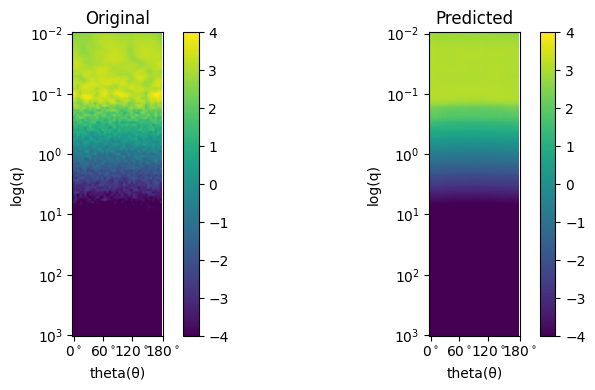

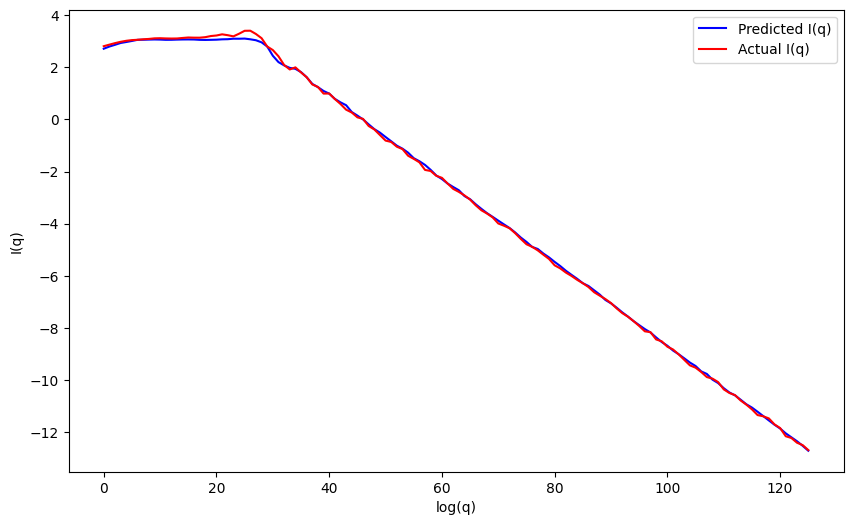

Mean Squared Error image: 0.07396523161315009
R-squared image: 0.9972968673057976
PSNR: 35.77552936599598
SSIM: 0.8656094771120145


In [ ]:
filtered = df_validate[df_validate['Sample ID'] == 214]
X_sample_test = filtered.drop(columns=['I_q', 'Sample ID'])
y_sample_test = filtered['I_q']
dmatrix_test = xgb.DMatrix(X_sample_test)
predicted = loaded_model.predict(dmatrix_test)
r2_score_= r2_score(y_sample_test,predicted)
predicted_matrix = np.reshape(predicted, (126,37))
original_matrix = np.reshape(y_sample_test.to_numpy(), (126,37))
mse = mean_squared_error(y_sample_test, predicted)
range_3_1 = np.max(y_sample_test) - np.min(predicted)
psnr_3_1 = skimage.metrics.peak_signal_noise_ratio(original_matrix, predicted_matrix,data_range=range_3_1)
ssim_3_1 = skimage.metrics.structural_similarity(original_matrix, predicted_matrix,data_range=range_3_1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
# Plotting the first image
im1 = ax1.imshow(original_matrix, cmap='viridis', vmin=-4, vmax=4)
x_positions = [0,12,24,37]
x_ticks = ["0$^\circ$", "60$^\circ$", "120$^\circ$", "180$^\circ$"]
y_positions = [0,25,50,75,100,125]
y_ticks = ["$10^{-2}$", "$10^{-1}$", "$10^0$", "$10^1$", "$10^2$", "$10^3$"]
ax1.set_xticks(x_positions,x_ticks)
ax1.set_yticks(y_positions,y_ticks)
ax1.set_title('Original')
ax1.set_xlabel("theta(θ)")
ax1.set_ylabel("log(q)")
cbar1 = fig.colorbar(im1, ax=ax1)
# Plotting the second image
im2 = ax2.imshow(predicted_matrix, cmap='viridis', vmin=-4, vmax=4)
ax2.set_xticks(x_positions,x_ticks)
ax2.set_yticks(y_positions,y_ticks)
ax2.set_title('Predicted')
ax2.set_xlabel("theta(θ)")
ax2.set_ylabel("log(q)")
cbar2 = fig.colorbar(im2, ax=ax2)
plt.tight_layout()
#fig.savefig('least_test_sample_1609_2D.svg', format='svg')
f_array_pred = np.reshape(predicted, (126, 37))
f_array_actual = np.reshape(np.array(y_sample_test), (126, 37))

average_pred = np.mean(f_array_pred, axis=1)
average_actual = np.mean(f_array_actual, axis=1)
plt.figure(figsize=(10, 6))
plt.xlabel("log(q)")
plt.ylabel("I(q)")
#plt.title("Average Predictions vs. Average Actual")

plt.plot(average_pred, label="Predicted I(q)", color="blue", linestyle="-")
plt.plot(average_actual, label="Actual I(q)", color="red", linestyle="-")
plt.legend()
fig = plt.gcf()
fig.savefig('least_test_sample_1609_1D.svg', format='svg')
plt.show()
print("Mean Squared Error image:", mse)
print("R-squared image:", r2_score_)
print('PSNR:',psnr_3_1)
print('SSIM:', ssim_3_1)

In [ ]:
max_psnr_index = mse_list.index(min(mse_list))
df_validate['Sample ID'].unique()[max_psnr_index]

459